<a href="https://colab.research.google.com/github/alexeybondarev/MTS_TETA_SMS/blob/main/MTS_TETA_SMS_Bondarev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача классификации спам сообщений в СМС, постановка задачи

С широким проникновением мобильного интернета и мессенджеров, операторы сотовой связи начали быстро терять выручку от одного из своих самых маржинальных каналов — сервиса SMS. Все операторы достаточно быстро перестроили свою тарифную политику и теперь получают доход от данного канала не напрямую, а в рамках общей подписки на пакетный тариф (300 минут звонков и 300 SMS, к примеру). В тоже время, появился и до сих пор широко распространен канал выручки для оператора от таргетированной SMS рекламы и разных сервисов, использующих SMS в качестве инструмента аутентификации пользователей или транзакций. К сожалению, в официальных финансовых отчетах не приводится какую долю выручки приносит данный канал, но если предположить, что он составляет даже 0,1%, то в денежном выражении это рынок на миллиард рублей в год. 

В связи с этим для оператора важно контролировать данный канал, так чтобы он был привлекателен для корпоративных клиентов и по-прежнему востребован у пользователей. 
Одним из показателей качества канала для пользователя является отсутствие спама, т. е. заведомо не релевантных и раздражающих сообщений. Проблема спама общая для всех электронных каналов коммуникаций и давно известная. Для канала SMS она характеризуется тем, что обработка спама может и должна проходить на стороне оператора.

В связи с этим бизнес задача может быть сформулирована следующих образом:

*   наличие автоматического сервиса блокировки SMS спама на стороне оператора, к которому принадлежит абонент.
*   сервис должен работать с связке с SMS шлюзом оператора и не вносить существенных временных задержек (это может быть критично для финансовых транзакций), а также не требовать большого количества оборудования
*   качество сервиса должно быть высоким, особенно низким должны быть ошибки первого рода, но и качество фильтрации должно быть высоким, в идеале стремящимся к 100% 

С учетом объема рынка, который можно очень грубо оценить в миллиард рублей, при 4-х операторах связи в России, наличие такого сервиса у оператора может быть высоким конкурентным преимуществом. 
Дополнительные 10% рынка, полученные у конкурентов, это дополнительные 100 млн рублей годовой выручки. 

# Получение данных и предобработка

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch

In [62]:
data = pd.read_csv('/content/gdrive/My Drive/spam.csv', engine='python')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [63]:
data.dropna(axis=1, inplace=True)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [64]:
data.rename(columns={"v1":"label", "v2":"text"}, inplace=True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [65]:
data.label[data.label == 'ham'] = 0
data.label[data.label == 'spam'] = 1
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Использование готовой модели из библиотеки Huggingface




В данной задаче исходными данными являются тексты, в связи с этим естественной гипотезой является использование SOTA подходов для работы с текстами, построенными на архитектуре трансформеров. Ожидается, что данные модели должны показать лучшее качество. 
В качестве первого эксперимента воспользуемся готовой моделью из библиотеки Huggingface - https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection
Данная модель построена поверх Bern-tiny и натренирована на задаче детекции спам в СМС сообщениях

In [9]:
! pip install datasets transformers[sentencepiece]

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

In [11]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [12]:
num_batches = 10
raw_inputs = data.text.to_list()
labels = data.label.to_list()

batch_size = len(raw_inputs) // num_batches
print('batch size = ', batch_size)

total_predictions = []

for i in range(num_batches):
  batch = raw_inputs[i*batch_size: (i+1)*batch_size]
  inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt") 
  outputs = model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  total_predictions.extend(np.argmax(predictions.detach().numpy(), axis = 1))

batch = raw_inputs[10*batch_size: len(raw_inputs)]
inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt") 
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
total_predictions.extend(np.argmax(predictions.detach().numpy(), axis = 1))

print(len(total_predictions))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


batch size =  557
5572


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score
import seaborn as sns

In [14]:
from sklearn.metrics import confusion_matrix
categories=['Ham', 'Spam']
def seaborn_conf(y, ypred):
    y_true = ["Ham", "Spam"]
    y_pred = ["Ham", "Spam"]
    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()

Accuracy: 0.9838478104809764


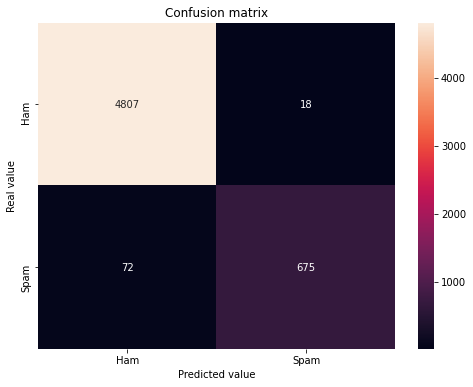

In [15]:
print('Accuracy: {}'.format(accuracy_score(labels, total_predictions)))
seaborn_conf(labels, total_predictions)

In [16]:
print(classification_report(labels, total_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4825
           1       0.97      0.90      0.94       747

    accuracy                           0.98      5572
   macro avg       0.98      0.95      0.96      5572
weighted avg       0.98      0.98      0.98      5572



Вывод по эксперименту.


1.   Действительно модель показывает высокое качестве, accuracy 98% и precision 97% на спам сообщениях. Также отметим низкое количество ошибочно определенных не спам сообщений, хотя их наличие все равно повод задуматься об улучшении в данном направлении (мы не должны терять не спам сообщения)
2.   Недостаток модели - её размер и требования по памяти. Инференс на всем датасете был невозможен из-за нехватки памяти, пришлось разбивать на батчи. В продуктовой среде это означает, что будут ограничения по количеству одновременно обрабатываемых сообщений или высокие требования к объему памяти на серверах
3.   Есть основания предположить, что обучение данной конкретной модели происходило на том же датасете и мы имеем дело с переобучением, чтобы это проверить следует построить собственную модель с разделением на обучающую и тестовую выборки






# Построение собственной модели классификации с использованием Bert из Huggingface

Учитывая успешные результаты первого эксперимента, следующая задача - показать, что аналогичную модель можно построить, используя только предобученную модель общего плана (Bert-like) с самостоятельной головой классификации.

In [ ]:
!pip install transformers

In [44]:
import transformers
import string
import re
from sklearn.model_selection import train_test_split

In [29]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [72]:
# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
def clean_sentence(s):
    """Given a sentence remove its punctuation and stop words"""
    
    stop_words = set(stopwords.words('english'))
    s = s.translate(str.maketrans('','',string.punctuation)) # remove punctuation
    tokens = word_tokenize(s)
    cleaned_s = [w for w in tokens if w not in stop_words] # removing stop-words
    return " ".join(cleaned_s[:20]) # using the first 10 tokens only

data["text"] = data["text"].apply(clean_sentence)

In [67]:
tokenized = data["text"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized

0       [101, 2175, 18414, 17583, 2391, 4689, 2800, 11...
1       [101, 7929, 2474, 2099, 16644, 15536, 2546, 10...
2       [101, 2489, 4443, 1016, 1059, 2243, 2135, 4012...
3       [101, 1057, 24654, 2360, 2220, 7570, 2099, 105...
4       [101, 20976, 1045, 2123, 2102, 2228, 3632, 214...
                              ...                        
5567    [101, 2023, 3416, 2051, 2699, 1016, 3967, 1057...
5568    [101, 2097, 1038, 2183, 9686, 24759, 5162, 320...
5569          [101, 12063, 6888, 2061, 19092, 15690, 102]
5570    [101, 1996, 3124, 7743, 2075, 1045, 6051, 2066...
5571           [101, 20996, 10258, 2049, 2995, 2171, 102]
Name: text, Length: 5572, dtype: object

In [68]:
max_len = tokenized.apply(len).max() # get the length of the longest tokenized sentence

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) # padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded

array([[  101,  2175, 18414, ...,     0,     0,     0],
       [  101,  7929,  2474, ...,     0,     0,     0],
       [  101,  2489,  4443, ...,     0,     0,     0],
       ...,
       [  101, 12063,  6888, ...,     0,     0,     0],
       [  101,  1996,  3124, ...,     0,     0,     0],
       [  101, 20996, 10258, ...,     0,     0,     0]])

In [69]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [73]:
input_ids = torch.tensor(padded)  # create a torch tensor for the padded sentences
attention_mask = torch.tensor(attention_mask) # create a torch tensor for the attention matrix

with torch.no_grad():
    encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

In [74]:
X = encoder_hidden_state[0][:,0,:].numpy()

In [75]:
data["num_words"] = data["text"].apply(lambda s: len(re.findall(r'\w+', s))) # Count the number of words in the message
data["message_len"] = data["text"].apply(len) # get the length of the text message

In [76]:
data.head(2)

,label,text,num_words,message_len
0,0,Go jurong point crazy Available bugis n great ...,16,82
1,0,Ok lar Joking wif u oni,6,23


In [77]:
X = encoder_hidden_state[0][:,0,:].numpy()
X = np.hstack((X, data[["num_words", "message_len"]].to_numpy().reshape(-1, 2))) # addind the the engineered features from the beginning
y = data["label"].astype('int')

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [79]:
y_train.value_counts()

0    3619
1     560
Name: label, dtype: int64

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
rf_classifier = RandomForestClassifier(n_estimators=1500, class_weight="balanced", n_jobs=-1, random_state=42) # Create a baseline random forest (no cross-validation, no hyperparameter tuning)
model=RandomForestClassifier()
model.fit(X_train,y_train)
pred=model.predict(X_test)

Accuracy score 0.9784637473079684


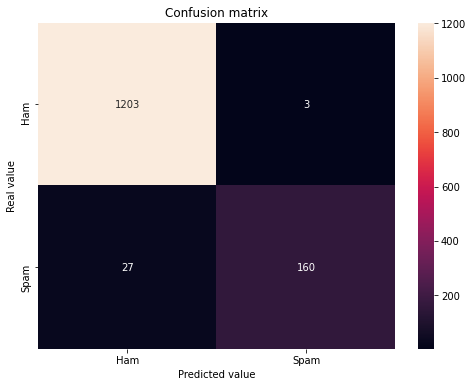

-----------------------------------------
Confusion Matrix
[[1203    3]
 [  27  160]]
-----------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       0.98      0.86      0.91       187

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



In [82]:
print('Accuracy score', accuracy_score(y_test, pred))
seaborn_conf(y_test, pred)
print('-----------------------------------------')
print('Confusion Matrix')
print(confusion_matrix(y_test, pred))
print('-----------------------------------------')
print('Classification Report')
print(classification_report(y_test, pred))

Выводы:


1.   Доказано, что качество по метрике accuracy можно получить 98%
2.   Значительно ниже получилась метрика recall для спам сообщений, однако в данном эксперименте не проводился подбор классификатора и его гиперпарметров. Скорее всего данную все метрики можно улучшить подбором классификатора и гиперпараметров
3. Обучение модели для получения латентного представления - главное бутылочное горлышко данного подхода. Во-первых, обучение на данном небольшом датасете заняло достаточно длительное время (несколько минут), к тому же пришлось ограничить размер СМС в 20 слов, чтобы обойти ограничение по памяти

